In [ ]:
!pip install -q kaggle

After installing Kaggle. Download the token from the kaggle website of a given dataset.
(https://www.kaggle.com/username/account) and select 'Create API Token'. This will trigger the download of kaggle.json,

link: https://www.kaggle.com/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection

In [1]:
from google.colab import files

files.upload()

{}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                        Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23           9834        298  1.0              
devansodariya/student-performance-data                          Student Performance Dataset                           7KB  2022-05-26 13:55:09           5308        166  0.9705882        
mohamedharris/supermart-grocery-sales-retail-analytics-dataset  Supermart Grocery Sales - Retail Analytics Dataset  191KB  2022-06-12 16:14:44            766         44  0.88235295       
sameepvani/nasa-nearest-earth-objects                       

In [ ]:
! kaggle datasets download -d wanderdust/skin-lesion-analysis-toward-melanoma-detection

100% 11.3G/11.3G [01:30<00:00, 168MB/s]
100% 11.3G/11.3G [01:30<00:00, 134MB/s]


In [ ]:
! unzip skin-lesion-analysis-toward-melanoma-detection.zip

Archive:  skin-lesion-analysis-toward-melanoma-detection.zip
  inflating: skin-lesions/test/melanoma/ISIC_0012258.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012356.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012369.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012395.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012425.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012758.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0012989.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013072.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013073.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013242.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013277.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013321.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013374.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013411.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013414.jpg  
  inflating: skin-lesions/test/melanoma/ISIC_0013455.j

In [ ]:
import os 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

In [ ]:
import os
# Directory with training horse pictures
train_melanoma_dir = os.path.join('skin-lesions/train/melanoma')

# Directory with training human pictures
train_nevus_dir = os.path.join('skin-lesions/train/nevus')

# Directory with training human pictures
train_seborrheic_keratosis_dir = os.path.join('skin-lesions/train/seborrheic_keratosis')

# Directory with training melanoma pictures
test_melanoma_dir = os.path.join('skin-lesions/test/melanoma')

# Directory with training nevus pictures
test_nevus_dir = os.path.join('skin-lesions/test/nevus')

# Directory with training seborrheic_keratosis pictures
test_seborrheic_keratosis_dir = os.path.join('skin-lesions/test/seborrheic_keratosis')

In [ ]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-22 13:50:16--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   115MB/s    in 0.7s    

2022-06-22 13:50:17 (115 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)



# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Set training parameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Apply data augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
      )

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'skin-lesions/train',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow training images in batches of 128 using train_datagen generator
test_generator = validation_datagen.flow_from_directory(
        'skin-lesions/test',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 2000 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


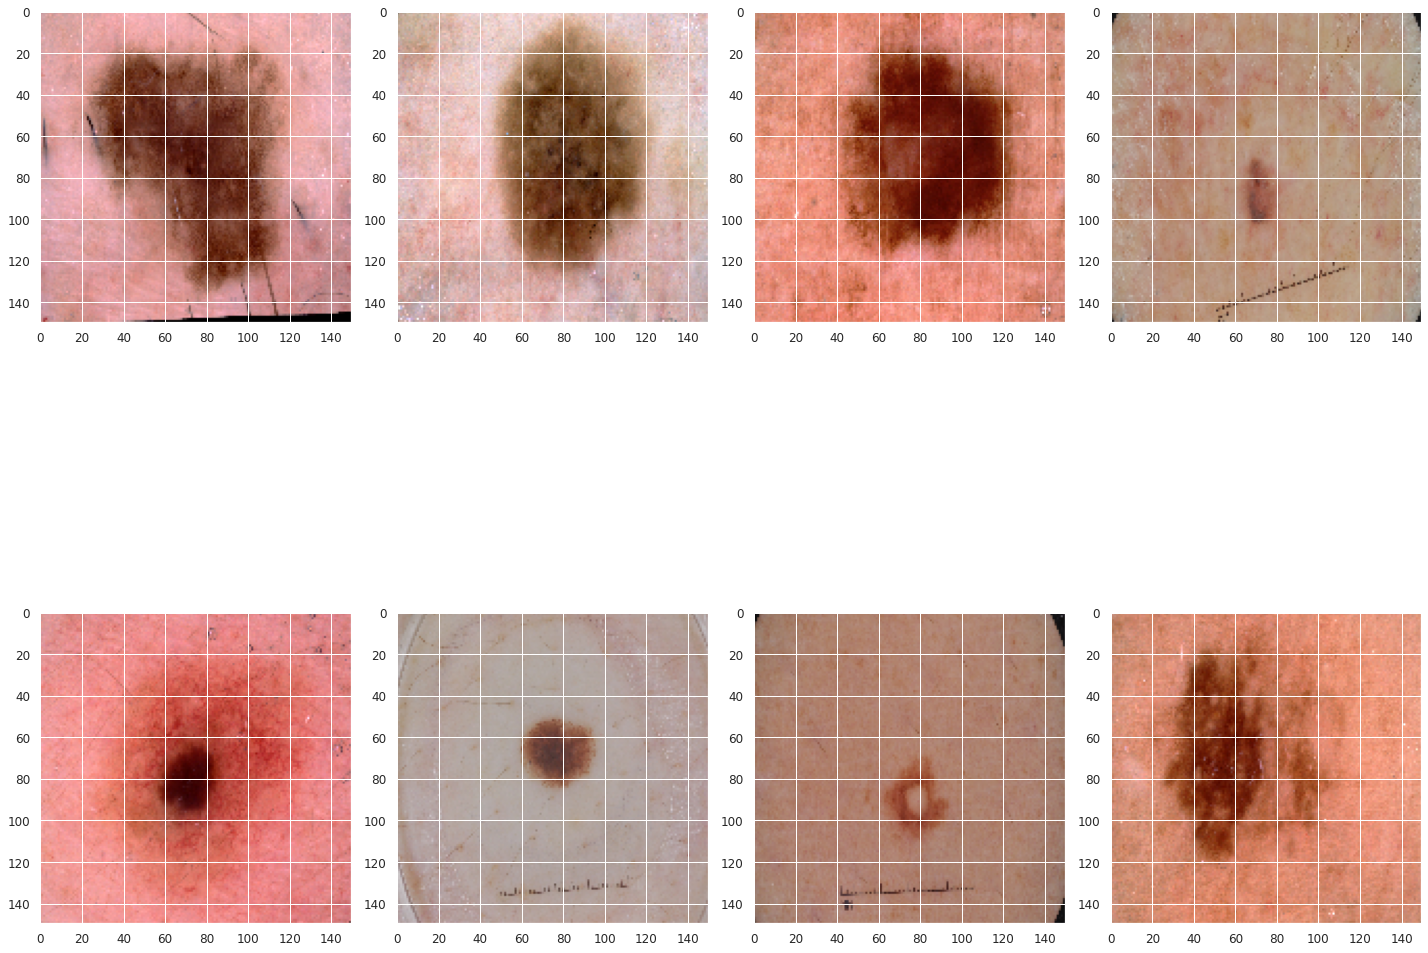

In [ ]:
sample_validation_images, sample_labels = next(test_generator) 
sample_labels = sample_labels.astype(np.int32)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(2, 4, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax, label in zip(images_arr, axes, labels):
        ax.imshow(img)
       # ax.set_xlabel(classes[label], fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)
    plt.tight_layout()
    plt.savefig('./sample_images.png')
    plt.show()

plotImages(sample_validation_images[:10], sample_labels[:10]) 

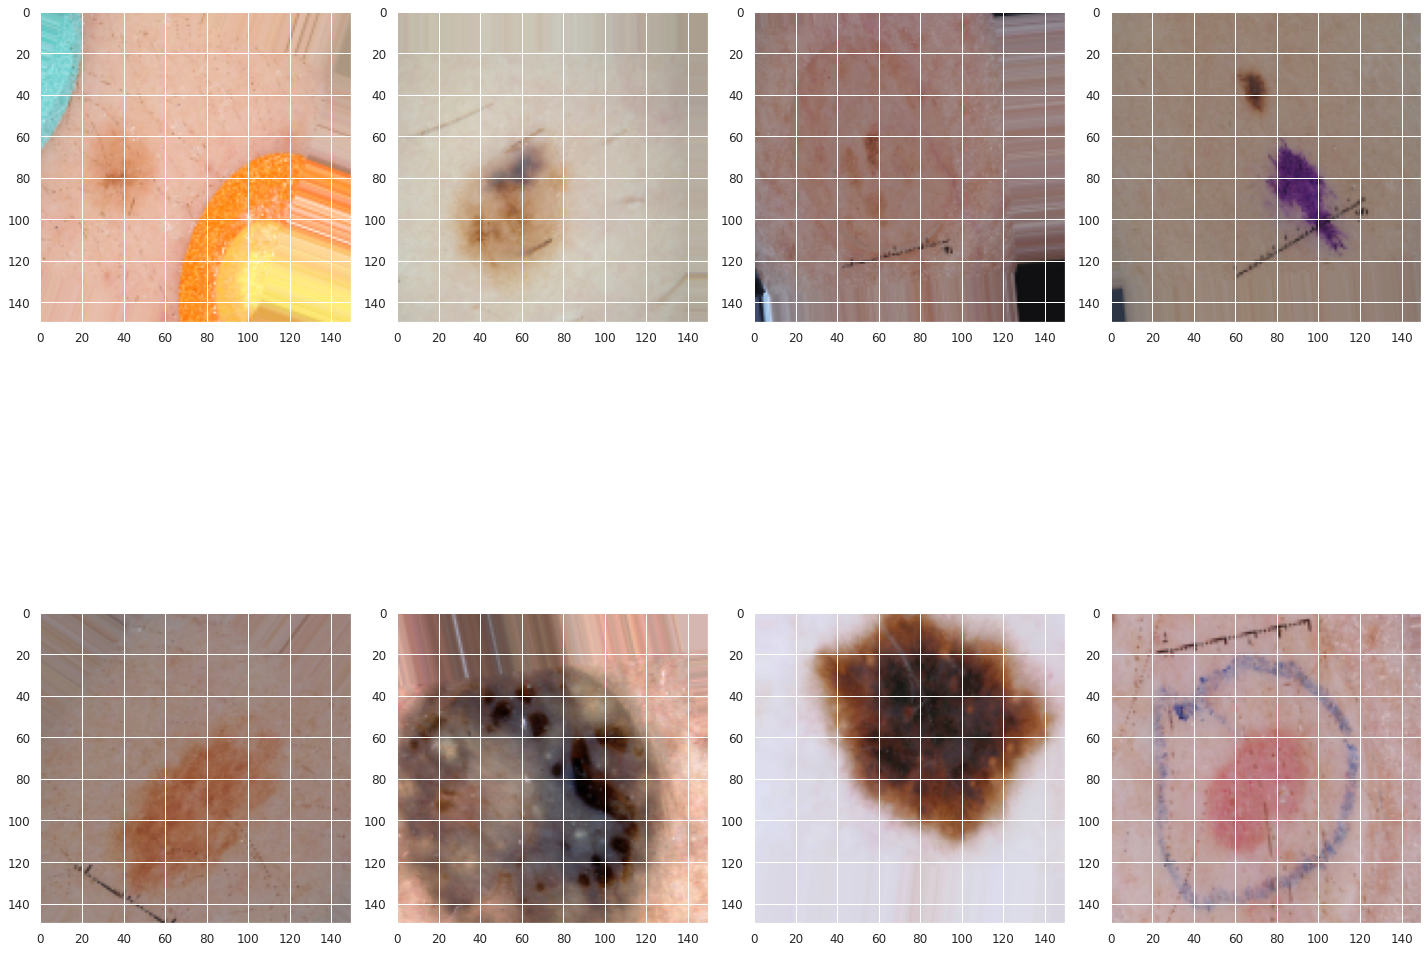

In [ ]:
sample_training_images, sample_labels = next(train_generator) 
sample_labels = sample_labels.astype(np.int32)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(2, 4, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax, label in zip(images_arr, axes, labels):
        ax.imshow(img)
       # ax.set_xlabel(classes[label], fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)
    plt.tight_layout()
    plt.savefig('./sample_augmented_images.png')
    plt.show()

plotImages(sample_training_images[:8], sample_labels[:8])

In [ ]:
# Constant for epochs
EPOCHS = 20

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=20,  
      epochs=EPOCHS,
      verbose=1,
      validation_data = test_generator,
      validation_steps=3
      )

Epoch 1/20
20/20 [==============================] - 460s 23s/step - loss: 4.4616 - accuracy: 0.5250 - val_loss: 1.4107 - val_accuracy: 0.6600
Epoch 2/20
20/20 [==============================] - 414s 21s/step - loss: 0.8672 - accuracy: 0.6735 - val_loss: 0.8352 - val_accuracy: 0.6733
Epoch 3/20
20/20 [==============================] - 414s 21s/step - loss: 0.7135 - accuracy: 0.6935 - val_loss: 0.7182 - val_accuracy: 0.6900
Epoch 4/20
20/20 [==============================] - 412s 21s/step - loss: 0.6532 - accuracy: 0.7190 - val_loss: 0.6869 - val_accuracy: 0.6867
Epoch 5/20
20/20 [==============================] - 411s 21s/step - loss: 0.6430 - accuracy: 0.7140 - val_loss: 0.7029 - val_accuracy: 0.6900
Epoch 6/20
20/20 [==============================] - 410s 21s/step - loss: 0.6143 - accuracy: 0.7470 - val_loss: 0.7290 - val_accuracy: 0.6867
Epoch 7/20
20/20 [==============================] - 409s 21s/step - loss: 0.6093 - accuracy: 0.7430 - val_loss: 0.7174 - val_accuracy: 0.6967
Epoch 

In [ ]:
predictions = model.predict(sample_validation_images[:10])
print([classes[np.argmax(prediction)] for prediction in predictions])

NameError: ignored

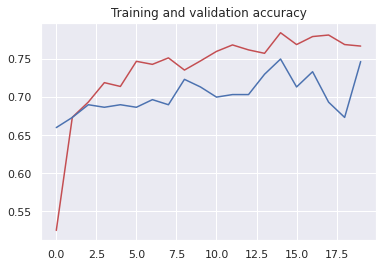

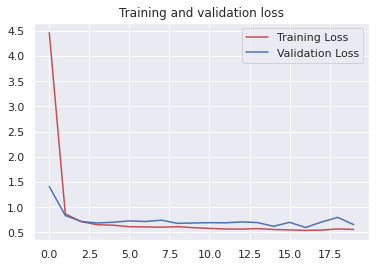

In [ ]:
import matplotlib.pyplot as plt

# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.savefig('./Training and validation Acc.png')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('./Training and validation loss.png')
plt.show()

In [ ]:
print(tf.version.VERSION)

2.8.2


In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import pathlib

In [ ]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)
# model.save("/content/models/dr.h5")

INFO:tensorflow:Assets written to: saved_model/1/assets


In [ ]:
export_dir = 'saved_model/2'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('/content/model.tflite')
tflite_model_file.write_bytes(tflite_model)

47758960

In [ ]:
tflite_model_file = pathlib.Path('/content/model2.tflite')
tflite_model_file.write_bytes(tflite_model)

In [ ]:
from google.colab import files

In [ ]:
files.download(tflite_model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import time
os.system("cp /content/model.tflite '/content/gdrive/My Drive/Colab Notebooks/data/'")
os.system("cp /content/foo.png '/content/gdrive/My Drive/Colab Notebooks/data/'")

In [ ]:
import time
os.system("cp /content/model2.tflite '/content/gdrive/My Drive/Colab Notebooks/data/'")
os.system("cp /content/foo.png '/content/gdrive/My Drive/Colab Notebooks/data/'")